In [1]:
# the SARSA method to find the optimal policy and value function
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

In [2]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [3]:
def random_action(a, eps=0.1):
  # epsilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [4]:
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [5]:
# no policy initialization,  policy is derived from most recent Q

# initialize Q(s,a)
Q = {}
states = grid.all_states()
for s in states:
  Q[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    Q[s][a] = 0
      
# initial Q values for all states in grid
print(Q)

{(0, 1): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (1, 2): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (0, 0): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (2, 3): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (2, 0): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (1, 3): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (1, 0): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (2, 2): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (0, 3): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (0, 2): {'U': 0, 'R': 0, 'D': 0, 'L': 0}, (2, 1): {'U': 0, 'R': 0, 'D': 0, 'L': 0}}


In [6]:
update_counts = {}
update_counts_sa = {}
for s in states:
  update_counts_sa[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    update_counts_sa[s][a] = 1.0

In [7]:
# repeat until convergence
t = 1.0
deltas = []
for it in range(10000):
  if it % 100 == 0:
    t += 1e-2
  if it % 2000 == 0:
    print("iteration:", it)

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a = max_dict(Q[s])[0]
  a = random_action(a, eps=0.5/t)
  biggest_change = 0
  while not grid.game_over():
    r = grid.move(a)
    s2 = grid.current_state()

    # we need the next action as well since Q(s,a) depends on Q(s',a')
    # if s2 not in policy then it's a terminal state, all Q are 0
    a2 = max_dict(Q[s2])[0]
    a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

    # we will update Q(s,a) AS we experience the episode
    alpha = ALPHA / update_counts_sa[s][a]
    update_counts_sa[s][a] += 0.005
    old_qsa = Q[s][a]
    Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
    biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

    # we would like to know how often Q(s) has been updated too
    update_counts[s] = update_counts.get(s,0) + 1

    # next state becomes current state
    s = s2
    a = a2

  deltas.append(biggest_change)

iteration: 0


iteration: 2000


iteration: 4000


iteration: 6000
iteration: 8000


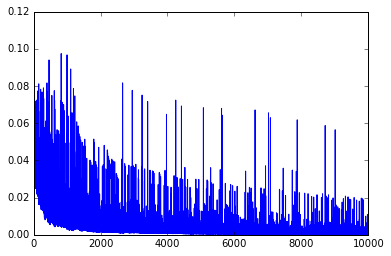

In [8]:
plt.plot(deltas)
plt.show()

In [8]:
# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
for s in grid.actions.keys():
  a, max_q = max_dict(Q[s])
  policy[s] = a
  V[s] = max_q

In [10]:
print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
  update_counts[k] = float(v) / total
print_values(update_counts, grid)

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.18| 0.00| 0.04| 0.00|
---------------------------
 0.18| 0.02| 0.03| 0.00|


In [11]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.49| 0.71| 1.00| 0.00|
---------------------------
 0.30| 0.00| 0.74| 0.00|
---------------------------
 0.12| 0.18| 0.41| 0.11|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |
